# <a href="https://mipt-stats.gitlab.io/courses/ad_fivt.html">Введение в анализ данных</a>

## Парадокс времени ожидания: а что в реальной жизни?

В <a href="https://mipt-stats.gitlab.io/courses/ad_fivt/lec4_means.html#3.-Когда-придет-мой-автобус?-Или-каково-среднее-время-ожидания-автобуса.">предыдущем примере</a> мы посмотрели на то, какие эффекты возникают в случае если автобусы прибывают на остановку с одинаковой интенсивностью независимо друг от друга. Выполняется ли это в реальности?

Исследуем данные о запланированном и фактическом времени прибытия для автобусов RapidRide маршрутов C, D и E на автобусной остановке 3rd&Pike в центре Сиэтла. Ниже приведена схема общественного транспорта Сиэтла, на которой красными линиями отмечены рассматриваемые автобусные маршруты.

Сами данные и идея исследования взяты из <a target="_blank" href="https://habr.com/ru/post/428610/">статьи на Хабре</a>.

<a href="https://seattletransitmap.com/app/"><img src="https://mipt-stats.gitlab.io/courses/ad_fivt/bus.png
" alt="Схема автобусных маршрутов города Сиэтл"></a>

In [1]:
import numpy as np
import pandas as pd
from random import choices, shuffle
import scipy.stats as sps
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style='whitegrid', font_scale=1.3, palette='Set2')

Загрузим данные с помощью библиотеки `pandas`, с которой вы уже должны были <a href="https://mipt-stats.gitlab.io/courses/python/08_pandas1.html">познакомиться</a>. Напечатаем также несколько первых строк таблицы. В данных есть следующая информация:
* `OPD_DATE` &mdash; дата события;
* `VEHICLE_ID` &mdash; номер транспортного средства;
* `RTE` &mdash; номер маршрута;
* `DIR` &mdash; направление движения (на север или на юг);
* `TRIP_ID` &mdash; идентификатор рейса;
* `STOP_ID` &mdash; идентификатор остановки;
* `STOP_NAME` &mdash; наименование остановки;
* `SCH_STOP_TM` &mdash; время прибытия по расписанию (**sch**edule);
* `ACT_STOP_TM` &mdash; время прибытия по факту (**act**ual);

In [2]:
df = pd.read_csv('arrival_times.csv')
df.head()

OPD_DATE  VEHICLE_ID  RTE DIR   TRIP_ID  STOP_ID  \
0  2016-03-26        6201  673   S  30908177      431   
1  2016-03-26        6201  673   S  30908033      431   
2  2016-03-26        6201  673   S  30908028      431   
3  2016-03-26        6201  673   S  30908019      431   
4  2016-03-26        6201  673   S  30908252      431   

                 STOP_NAME SCH_STOP_TM ACT_STOP_TM  
0  3RD AVE & PIKE ST (431)    01:11:57    01:13:19  
1  3RD AVE & PIKE ST (431)    23:19:57    23:16:13  
2  3RD AVE & PIKE ST (431)    21:19:57    21:18:46  
3  3RD AVE & PIKE ST (431)    19:04:57    19:01:49  
4  3RD AVE & PIKE ST (431)    16:42:57    16:42:39

### 1. Обработка и первичный анализ данных

В данных всего 39 157 записей

In [3]:
df.shape

(39157, 9)

Проверим, есть ли пропуски

In [4]:
df.isna()

OPD_DATE  VEHICLE_ID    RTE    DIR  TRIP_ID  STOP_ID  STOP_NAME  \
0         False       False  False  False    False    False      False   
1         False       False  False  False    False    False      False   
2         False       False  False  False    False    False      False   
3         False       False  False  False    False    False      False   
4         False       False  False  False    False    False      False   
...         ...         ...    ...    ...      ...      ...        ...   
39152     False       False  False  False    False    False      False   
39153     False       False  False  False    False    False      False   
39154     False       False  False  False    False    False      False   
39155     False       False  False  False    False    False      False   
39156     False       False  False  False    False    False      False   

       SCH_STOP_TM  ACT_STOP_TM  
0            False        False  
1            False        False  
2            False        False  
3            False        False  
4            False        False  
...            ...          ...  
39152        False        False  
39153        False        False  
39154        False        False  
39155        False        False  
39156        False        False  

[39157 rows x 9 columns]

На первый взгляд не видно. Посчитаем долю пропусков по столбцам, усреднив логические константы. В данном случае сначала произошло преобразование к 0 и 1.

In [5]:
df.isna().mean()

OPD_DATE       0.000000
VEHICLE_ID     0.000000
RTE            0.000000
DIR            0.000000
TRIP_ID        0.000000
STOP_ID        0.000000
STOP_NAME      0.000000
SCH_STOP_TM    0.006129
ACT_STOP_TM    0.000000
dtype: float64

Теперь уже видно, что для 0.6% рейсов не задано время прибытия.

Посмотрим, что это за рейсы. Для этого сначала с помощью функции `any` определим для каждого рейса, есть для него *хотя бы один* пропуск.

In [6]:
df.isna().any(axis=1)

0        False
1        False
2        False
3        False
4        False
         ...  
39152    False
39153    False
39154    False
39155    False
39156    False
Length: 39157, dtype: bool

Теперь мы можем извлеть все строки таблицы с пропусками.

In [7]:
df[df.isna().any(axis=1)]

OPD_DATE  VEHICLE_ID  RTE DIR  TRIP_ID  STOP_ID  \
383    2016-04-01        6206  673   S        0      431   
471    2016-03-31        6207  673   S        0      431   
588    2016-03-30        6208  673   S        0      431   
599    2016-03-30        6200  673   S        0      431   
685    2016-03-29        6213  673   S        0      431   
...           ...         ...  ...  ..      ...      ...   
37327  2016-05-10        6215  674   N        0      578   
37328  2016-05-10        6215  674   N        0      578   
37570  2016-05-12        6218  674   N        0      578   
37670  2016-05-13        6212  674   N        0      578   
39107  2016-05-27        6099  674   N        0      578   

                     STOP_NAME SCH_STOP_TM ACT_STOP_TM  
383    3RD AVE & PIKE ST (431)         NaN    16:00:57  
471    3RD AVE & PIKE ST (431)         NaN    15:28:05  
588    3RD AVE & PIKE ST (431)         NaN    14:52:36  
599    3RD AVE & PIKE ST (431)         NaN    15:12:06  
685    3RD AVE & PIKE ST (431)         NaN    17:56:29  
...                        ...         ...         ...  
37327  3RD AVE & PIKE ST (578)         NaN    15:25:47  
37328  3RD AVE & PIKE ST (578)         NaN    17:44:05  
37570  3RD AVE & PIKE ST (578)         NaN    18:27:55  
37670  3RD AVE & PIKE ST (578)         NaN    19:04:25  
39107  3RD AVE & PIKE ST (578)         NaN    14:51:34  

[240 rows x 9 columns]

Давайте удали пропуски из данных, чтобы они не мешали нашему дальнейшему анализу. Параметры функции предписывают удалять *строки*, в которых есть *хотя бы один* пропуск в любой из колонок.

In [8]:
df = df.dropna(axis=0, how='any')

Посмотрим на диаппазон дат в датасете. Всего у нас есть данные за 2 месяца &mdash; с 26 марта 2016 по 27 мая 2016.

In [9]:
df['OPD_DATE'].min(), df['OPD_DATE'].max()

('2016-03-26', '2016-05-27')

Уникальные идентификаторы автобусных маршрутов

In [10]:
df['RTE'].unique()

array([673, 675, 674])

Направления движения

In [11]:
df['DIR'].unique()

array(['S', 'N'], dtype=object)

Идентификаторы автобусных остановок

In [12]:
df['STOP_ID'].unique()

array([431, 578])

Как видим остановки две. Если мы составим с помощью функции <a href="https://mipt-stats.gitlab.io/courses/python/10_pandas2.html#4.1-Функция-pd.crosstab">`pd.crosstab`</a> таблицу, в которой показано, сколько рейсов было на каждой остановке по каждому из направлений, то мы сможем догадаться, что два идентификатора означаю одну и ту же остановку по разные стороны движения.

In [13]:
pd.crosstab(columns=df['DIR'], index=df['STOP_ID'])

DIR          N      S
STOP_ID              
431          0  19318
578      19599      0

Также с помощью этой функции мы можем составить таблицу с количеством автобусов каждого маршрута за каждые сутки

In [14]:
daily_counts = pd.crosstab(columns=df['RTE'], index=df['OPD_DATE'])
daily_counts

RTE         673  674  675
OPD_DATE                 
2016-03-26  176  178  159
2016-03-27  153  153  140
2016-03-28  232  227  219
2016-03-29  231  231  221
2016-03-30  228  230  221
...         ...  ...  ...
2016-05-23  229  230  220
2016-05-24  233  229  220
2016-05-25  232  231  221
2016-05-26  229  203  220
2016-05-27  230  229  222

[63 rows x 3 columns]

И построить с ее помощью график автобусов за день по маршрутам. На этом графике мы четко наблюдаем некоторую периодичность, которую называют **недельной сезонностью**. Действительно, мы видим, что 7-дневные интервалы, из которых в течении пяти дней наблюдается достаточно большое количество автобусов по каждому из маршрутов, а в остальные два дня &mdash; существенно меньше.

В целом стоит отметить, что исследование сезонностей в данных &mdash; важная часть работы с временн*ы*ми данными.

/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


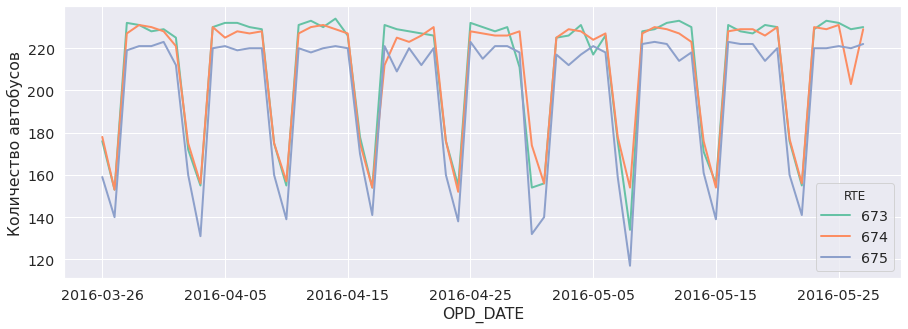

In [15]:
with sns.axes_style('darkgrid'):
    daily_counts.plot(figsize=(15, 5), lw=2);
    plt.ylabel('Количество автобусов')

Для удобства дальнейшего анализа объединим дату и время в одну метку времени.

In [16]:
df['scheduled'] = pd.to_datetime(df['OPD_DATE'] + ' ' + df['SCH_STOP_TM'])
df['actual'] = pd.to_datetime(df['OPD_DATE'] + ' ' + df['ACT_STOP_TM'])

Однако, такой операцией мы могли привнести ошибки в данные.

Давайте посчитаем для каждого автобуса время между прибытием по расписанию и фактическим временем прибытия.

In [17]:
minute = np.timedelta64(1, 'm')
hour = 60 * minute

diff_hrs = (df['actual'] - df['scheduled']) / hour

Посмотрим на гистограмму

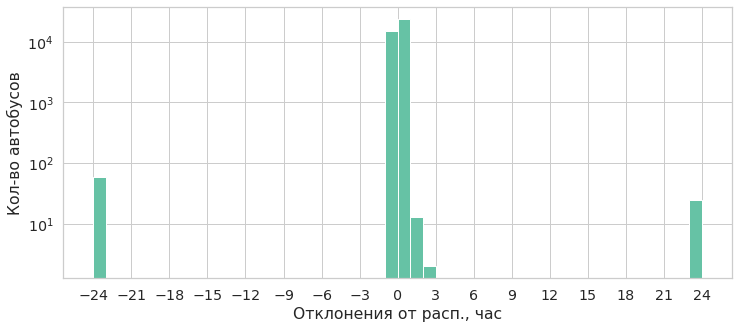

In [18]:
plt.figure(figsize=(12, 5))
plt.hist(diff_hrs, bins=48, log=True)
plt.xticks(range(-24, 25, 3))
plt.xlabel('Отклонения от расп., час')
plt.ylabel('Кол-во автобусов');

Оказывается, что несколько автобусов приезжали на сутки раньше, а еще несколько &mdash; на сутки позже. Как такое могло произойти?

Вспомним, что мы искусственно склеили дату с временем суток. У нас имеется две отметки времени суток для каждого рейса, но дата одна, и она соответствует времени прибытия по расписанию. Таким образом, возможны две следующие ситуации.
* Время прибытия по расписанию &mdash; сразу после полуночи, а автобус пришел немного раньше. Тем самым при склейке даты и времени мы получили, что как будто он пришел на сутки позже.
* Время прибытия по расписанию &mdash; непосредственно до полуночи, а автобус немного опоздал. И при склейке даты и времени мы получили, что как будто он пришел на сутки раньше.

Исправим фактическое время прибытия руками для тех рейсов, где отклонение по модулю слишком большое.

In [19]:
df.loc[diff_hrs > 20, 'actual'] -= 24 * hour
df.loc[diff_hrs < -20, 'actual'] += 24 * hour

И теперь посчитаем время отклонения факта от расписания в минутах

In [20]:
df['minutes_late'] = (df['actual'] - df['scheduled']) / minute

Переобозначим технические идентификаторы маршрутов на те, которые видят пассажиры. Также переобозначим направления движения.

In [21]:
df['route'] = df['RTE'].replace({673: 'C', 674: 'D', 675: 'E'}).astype('category')
df['direction'] = df['DIR'].replace({'N': 'север', 'S': 'юг'}).astype('category')

Оставим только интересующие нас столбцы

In [22]:
df = df[['route', 'direction', 'scheduled', 'actual', 'minutes_late']]

И посмотрим на данные

In [23]:
df.head()

route direction           scheduled              actual  minutes_late
0     C        юг 2016-03-26 01:11:57 2016-03-26 01:13:19      1.366667
1     C        юг 2016-03-26 23:19:57 2016-03-26 23:16:13     -3.733333
2     C        юг 2016-03-26 21:19:57 2016-03-26 21:18:46     -1.183333
3     C        юг 2016-03-26 19:04:57 2016-03-26 19:01:49     -3.133333
4     C        юг 2016-03-26 16:42:57 2016-03-26 16:42:39     -0.300000

### 2. Исследование отклонения от расписания

Для каждого направления и каждого маршрута визуализируем гистограмму отклонения от расписания в минутах.

Визуализацию выполним в виде таблицы с помощью класса <a target="_blank" href="https://seaborn.pydata.org/generated/seaborn.FacetGrid.html">`FacetGrid`</a>. Работа функции несколько похожа на функцию <a target="_blank" href="https://mipt-stats.gitlab.io/courses/python/10_pandas2.html#4.2-Функция-pd.pivot_table">`pd.pivot_table`</a>, только вместо применения аггрегирующией функции рисуется график. Функция построения каждого графика передается в метод `map`.

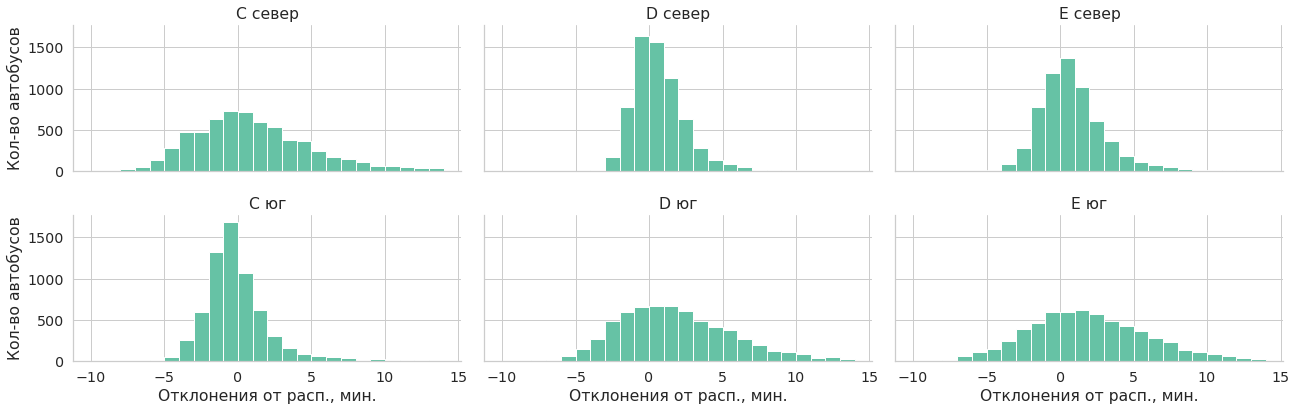

In [24]:
g = sns.FacetGrid(df, row="direction", col="route", height=3, aspect=2)
g.map(plt.hist, "minutes_late", bins=np.arange(-10, 15))
g.set_titles('{col_name} {row_name}')
g.set_axis_labels('Отклонения от расп., мин.', 'Кол-во автобусов');

Заметим, что **автобусы ближе к графику в начале маршрута и больше отклоняются от него к концу**. Если внимательно посмотреть на схему маршрутов, то можно увидеть, что исследуемая остановка находится на северной части маршрута С, и на южных частях машрутов D и Е. Тем самым, при следовании по маршруту C на юг наша остановка близка к началу маршрута, тем самым отклонения от расписания в основном небольшие. Аналогично с маршрутами D и E при движении на север. В остальных случаях наблюдается больший разброс отклонений.


Однако нам хотелось бы еще посмотреть на интервалы между автобусами. Сначала посчитаем интервалы между автобусами по расписанию и фактические.

In [25]:
def compute_headway(times):
    """ Вычисляет интервалы между соседними моментами времени в минутах. """
    minute = np.timedelta64(1, 'm')
    return times.sort_values().diff() / minute

# сгруппируем по маршруту и по направлению
grouped = df.groupby(['route', 'direction'])
# для каждой группы посчитаем интервалы определенной выше функцией
df['actual_interval'] = grouped['actual'].transform(compute_headway)
df['scheduled_interval'] = grouped['scheduled'].transform(compute_headway)

Визуализируем фактические интервалы между автобусами

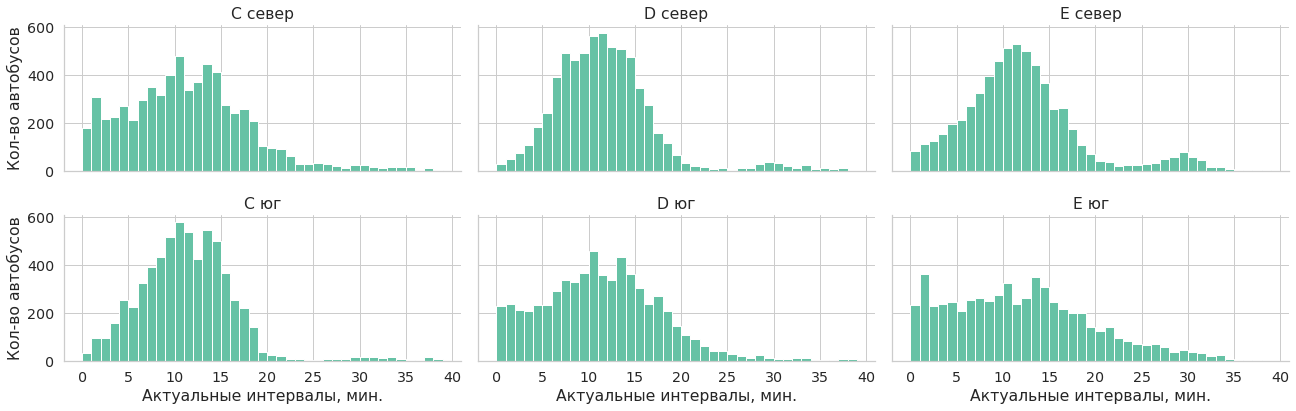

In [26]:
g = sns.FacetGrid(df.dropna(), row="direction", col="route", height=3, aspect=2)
g.map(plt.hist, "actual_interval", bins=np.arange(40))
g.set_titles('{col_name} {row_name}')
g.set_axis_labels('Актуальные интервалы, мин.', 'Кол-во автобусов');

Видим, что **фактические интервалы даже по каждому отдельному маршруту, видимо, не подчиняются экспоненциальному распределению.**

Однако, не все так просто. В прошлый раз мы рассматривали случай, при котором автобусы приходят на остановку независимо друг от друга с одинаковой интенсивностью. Но это не так, для этого достаточно посмотреть на графики временных рядов выше. Как мы ранее заметили, в выходные дни автобусы ходят реже. Кроме того, наверняка в час пик автобусы ходят чаще, чем в вечерне-ночное время.

Посмотрим на интервалы между автобусами по расписанию

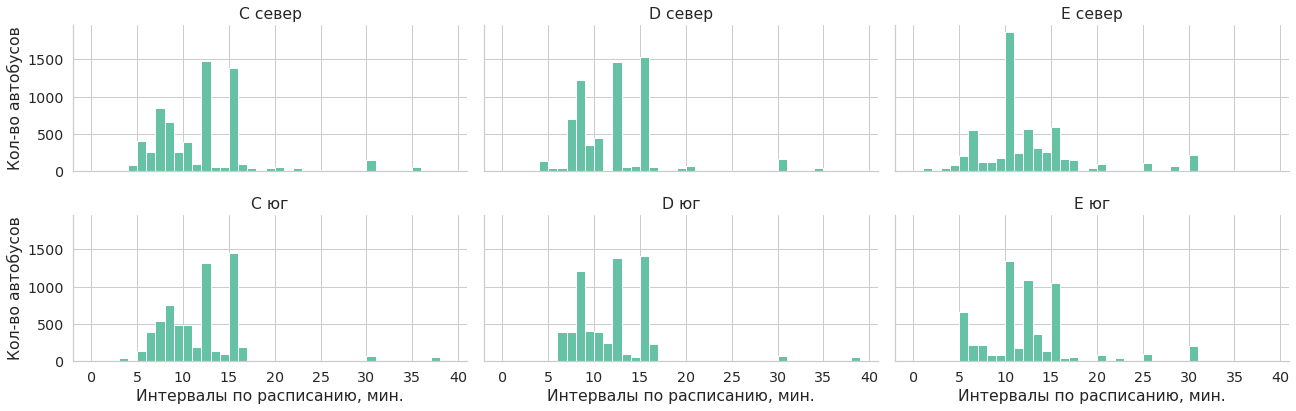

In [27]:
g = sns.FacetGrid(df.dropna(), row="direction", col="route", height=3, aspect=2)
g.map(plt.hist, "scheduled_interval", bins=np.arange(40))
g.set_titles('{col_name} {row_name}')
g.set_axis_labels('Интервалы по расписанию, мин.', 'Кол-во автобусов');

Тут мы уже видим, что по расписанию есть **много разных значений запланированных интервалов между автобусами.**

### 3. Исследование для однородных ожидаемых интервалов

Тем не менее, есть частые интервалы по расписанию: 10, 12 и 15 минут. Например, есть почти 2000 автобусов в северную сторону с запланированным интервалом в 10 минут.
Давайте посмотрим внимательнее на эти интервалы.

Составим условие выбора строк из таблицы

In [28]:
df['scheduled_interval'].isin([10, 12, 15])

0        False
1        False
2        False
3        False
4        False
         ...  
39152     True
39153     True
39154     True
39155     True
39156     True
Name: scheduled_interval, Length: 38917, dtype: bool

Составим подтаблицу с помощью данного условия

In [29]:
subset = df[df['scheduled_interval'].isin([10, 12, 15])]

Сгруппируем по маршруту, по направлению и по интервалам среди выбранных интервалов.

In [30]:
grouped = subset.groupby(['route', 'direction', 'scheduled_interval'])

In [31]:
def stack_sequence(data):
    """ Перераспределение времени так, как будто события происходят последовательно. """
    
    # сортируем по ожидаемому времени прибытия
    data = data.sort_values('scheduled')
    # переопределим время прибытия так, как будто они шли подряд
    data['scheduled'] = data['scheduled_interval'].cumsum()
    # соответствующе переопределим фактическое время на основе имеющегося отклонения
    data['actual'] = data['scheduled'] + data['minutes_late']
    # посчитаем фактические интервалы по скорректированному фактическому времени
    data['actual_interval'] = data['actual'].sort_values().diff()
    return data

Применим эту функцию к нашим группам

In [32]:
sequenced = grouped.apply(stack_sequence).reset_index(drop=True)
sequenced.head()

route direction  scheduled     actual  minutes_late  actual_interval  \
0     C     север       10.0  12.400000      2.400000              NaN   
1     C     север       20.0  27.150000      7.150000         0.183333   
2     C     север       30.0  26.966667     -3.033333        14.566667   
3     C     север       40.0  35.516667     -4.483333         8.366667   
4     C     север       50.0  53.583333      3.583333        18.066667   

   scheduled_interval  
0                10.0  
1                10.0  
2                10.0  
3                10.0  
4                10.0

Теперь визуализируем все отклонения от расписания в рамках выбранного интервала.

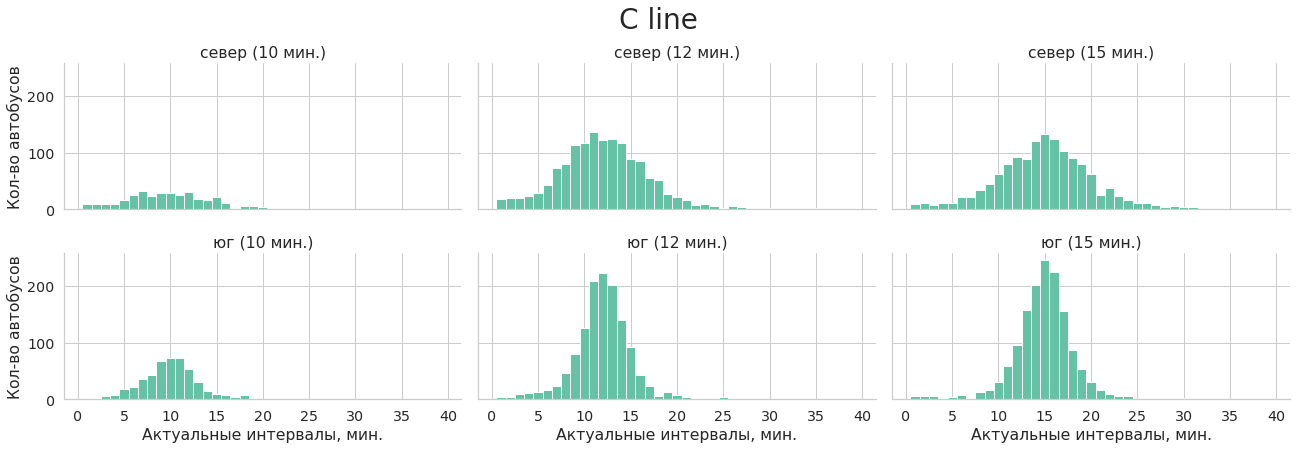

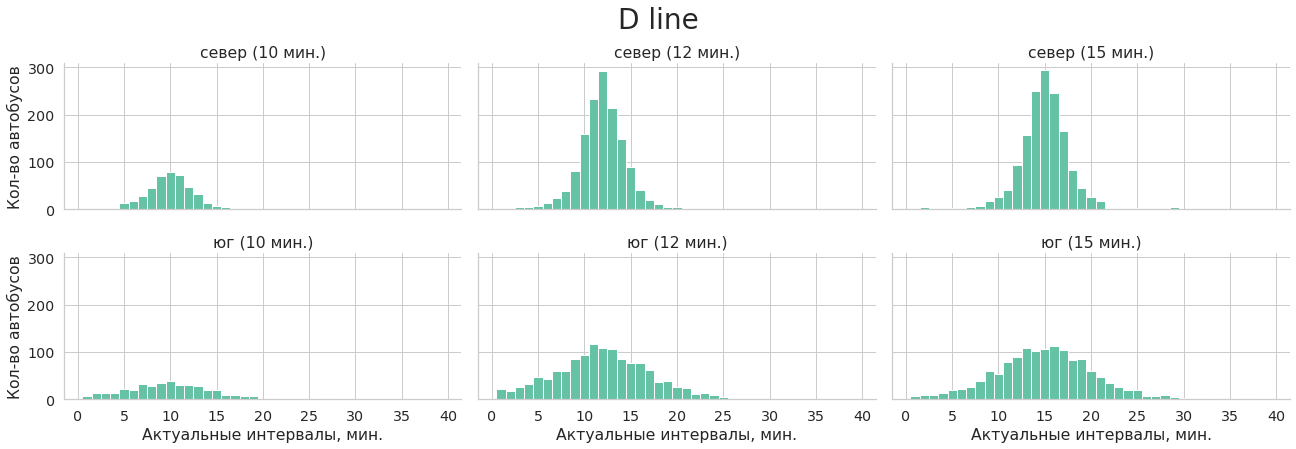

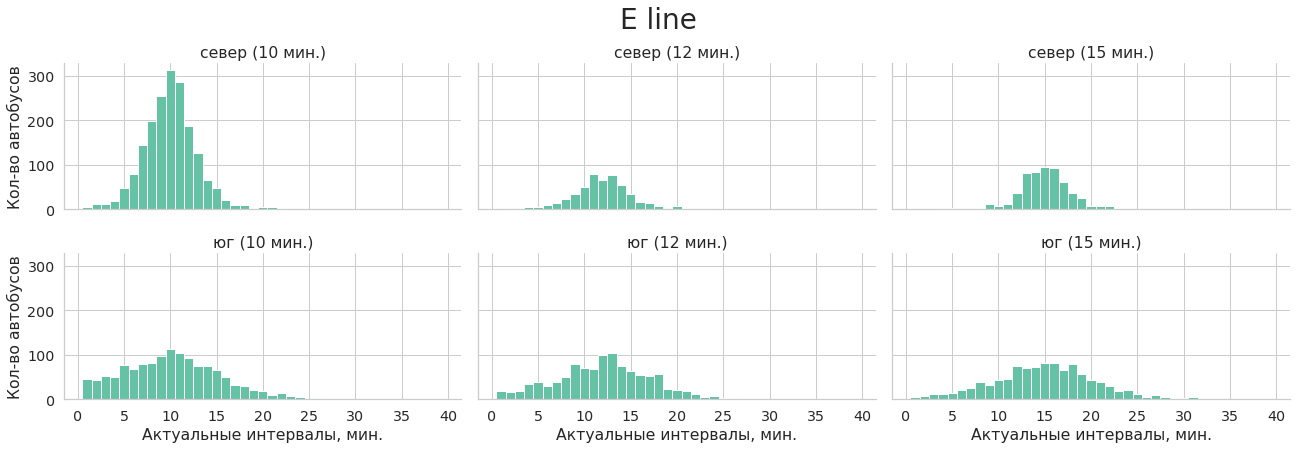

In [33]:
for route in ['C', 'D', 'E']:
    g = sns.FacetGrid(sequenced.query(f"route == '{route}'"),
                      row="direction", col="scheduled_interval", height=3, aspect=2)
    g.map(plt.hist, "actual_interval", bins=np.arange(40) + 0.5)
    g.set_titles('{row_name} ({col_name:.0f} мин.)')
    g.set_axis_labels('Актуальные интервалы, мин.', 'Кол-во автобусов');
    g.fig.suptitle(f'{route} line', y=1.05, fontsize=28)

Видим, что для каждого маршрута и направления при фиксированном интервале **распределение фактических интервалов близко к нормальному**. Оно достигает максимума около запланированного интервала и имеет стандартное отклонение (корень из дисперсии), которое меньше в начале маршрута (на юг для C, на север для D/E) и больше в конце. 

Также видно, что фактические интервалы прибытия определенно не соответствуют экспоненциальному распределению, что является основным предположением, на котором основан парадокс времени ожидания.

### 4. Симуляция пассажиров

Теперь оценим, сколько в среднем придется ждать пассажиру автобуса при данных интервалах движения. Для этого оформим код с <a href="https://mipt-stats.gitlab.io/courses/ad_fivt/lec4_means.html#3.-Когда-придет-мой-автобус?-Или-каково-среднее-время-ожидания-автобуса.">предыдущего ноутбука</a> в специальную функцию.

In [34]:
def simulate_wait_times(bus_arrival_times, n_passengers=1000000):
    """
    Моделирование времени ожидание пассажиров.
    
    bus_arrival_times -- моменты времени прибытия автобусов.
    n_passengers -- количество пассажиров для семплирования.
    """
    
    bus_arrival_times = np.array(bus_arrival_times)

    # сгенерируем для каждого пассажира время его прибытия на остановку
    passenger_times = sps.uniform(scale=bus_arrival_times.max()).rvs(size=n_passengers)
    # найдем время прибытия следующего автобуса поиском по отсортированному массиву
    i = np.searchsorted(bus_arrival_times, passenger_times, side='right')
    # вычислим интервал ожидания
    wait_times = bus_arrival_times[i] - passenger_times

    return wait_times

Произведем семплирование и посчитаем интервалы вместе с наиболее вероятным диаппазоном, считая, что мы работаем с нормальным распределением. Как мы помним, интервал, определяемый среднем и двумя стандартными отклонениями содержит чуть более 95% вероятностной массы.

In [35]:
# сгруппируем по маршрутам, направлениям и интервалам
grouped = sequenced.groupby(['route', 'direction', 'scheduled_interval'])
# применим семплирование
simulated = grouped['actual'].apply(simulate_wait_times)

# посчитаем и напечатаем интервалы
simulated = simulated.apply(lambda times: "{0:.1f} +/- {1:.1f}".format(times.mean(), 2*times.std()))
pd.DataFrame(simulated)

actual
route direction scheduled_interval              
C     север     10.0                7.8 +/- 25.3
                12.0                7.4 +/- 11.3
                15.0                8.8 +/- 12.9
      юг        10.0                6.3 +/- 12.7
                12.0                6.8 +/- 10.4
                15.0                8.4 +/- 14.5
D     север     10.0                6.1 +/- 14.3
                12.0                 6.5 +/- 9.3
                15.0                7.9 +/- 10.6
      юг        10.0                6.7 +/- 10.6
                12.0                7.5 +/- 11.8
                15.0                8.8 +/- 12.9
E     север     10.0                 5.5 +/- 7.5
                12.0                 6.5 +/- 8.5
                15.0                 7.9 +/- 9.8
      юг        10.0                6.7 +/- 11.2
                12.0                7.3 +/- 10.4
                15.0                8.7 +/- 12.0

Видим, что среднее время ожидания, возможно, на минуту или две больше половины интервала расписанию, но не равно этому интервалу, как подразумевает парадокс времени ожидания. Другими словами, **парадокс инспекции подтвержден, но парадокс времени ожидания не соответствует действительности.**

**Вывод.** 

Мы подтвердили, что в реальном мире автобусные маршруты подчиняются некоторой разновидности парадокса инспекции, однако основное предположение, лежащее в основе парадокса времени ожидания, — что прибытие автобусов происходит независимо друг от друга и с одинаковой интенсивностью — не является действительным.

На самом же деле в хорошо управляемой системе общественного транспорта есть специально структурированные расписания, чтобы избежать такого поведения: автобусы не начинают свои маршруты в случайное время в течение дня, а стартуют по расписанию, выбранному для наиболее эффективной перевозки пассажиров.